In [ ]:
# Import necessary libraries
import os
import zipfile
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Paths to the zip files in your notebook directory
zip_files = ["olive_peacock.zip", "olive_healthy.zip"]

# Unzip the files
for file_name in zip_files:
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        extract_path = file_name.replace(".zip", "")  # Extract to a folder with the same name as the zip file
        zip_ref.extractall(extract_path)
        print(f"Extracted {file_name} to {extract_path}")

# Define paths to the extracted directories
olive_peacock_path = 'olive_peacock'
olive_healthy_path = 'olive_healthy'




Extracted olive_peacock.zip to olive_peacock
Extracted olive_healthy.zip to olive_healthy


In [ ]:
import shutil

# Remove the __MACOSX directory
macosx_path = os.path.join('test_data', '__MACOSX')
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Removed __MACOSX folder.")

# Update the test directory path
test_dir = os.path.join('test_data', 'test')


In [ ]:
olive_peacock_path = '/content/olive_peacock/olive_peacock'
olive_healthy_path = '/content/olive_healthy/olive_healthy'

Visualizing olive peacock spot images:


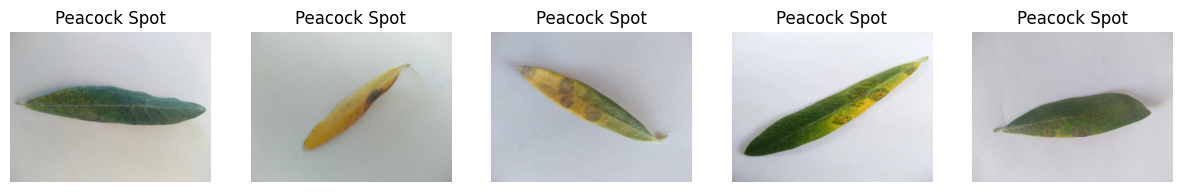

Visualizing healthy olive leaves:


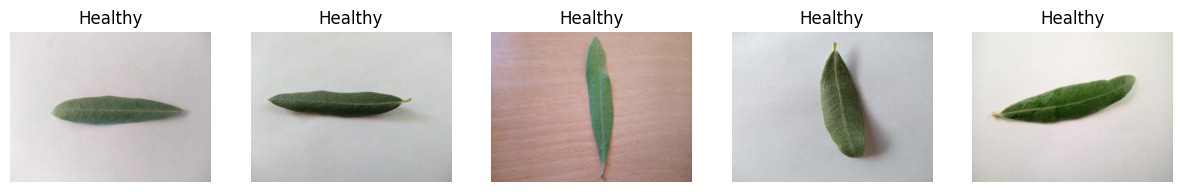

In [ ]:
# Function to visualize random images
def visualize_images(folder_path, category, n_images=5):
    files = list(Path(folder_path).glob('*.*'))  # Match all file types
    plt.figure(figsize=(15, 5))
    for i in range(min(n_images, len(files))):
        img = cv2.imread(str(files[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
    plt.show()

 # Visualize random images
print("Visualizing olive peacock spot images:")
visualize_images(olive_peacock_path, "Peacock Spot")

print("Visualizing healthy olive leaves:")
visualize_images(olive_healthy_path, "Healthy")

In [ ]:
# Count the number of images in each category
def count_images(folder_path):
    return len(list(Path(folder_path).glob('*.*')))  # Match all file types

print(f"Number of peacock spot images: {count_images(olive_peacock_path)}")
print(f"Number of healthy olive leaf images: {count_images(olive_healthy_path)}")


Number of peacock spot images: 777
Number of healthy olive leaf images: 830


In [ ]:
# Inspect one image for metadata (dimensions, channels, etc.)
def inspect_image(folder_path):
    files = list(Path(folder_path).glob('*.*'))
    if files:
        img = cv2.imread(str(files[0]))
        print(f"Dimensions: {img.shape}")
        print(f"Data Type: {img.dtype}")
    else:
        print("No images found!")

print("Inspecting a peacock spot image:")
inspect_image(olive_peacock_path)

print("Inspecting a healthy olive leaf image:")
inspect_image(olive_healthy_path)

Inspecting a peacock spot image:
Dimensions: (600, 800, 3)
Data Type: uint8
Inspecting a healthy olive leaf image:
Dimensions: (600, 800, 3)
Data Type: uint8


In [ ]:
# Check for corrupted files
def check_corrupted(folder_path):
    files = list(Path(folder_path).glob('*.*'))
    corrupted = []
    for file in files:
        try:
            img = cv2.imread(str(file))
            if img is None:
                corrupted.append(file)
        except Exception as e:
            corrupted.append(file)
    return corrupted

print("Checking for corrupted files in peacock spot dataset:")
corrupted_peacock = check_corrupted(olive_peacock_path)
print(f"Corrupted files: {corrupted_peacock}")

print("Checking for corrupted files in healthy dataset:")
corrupted_healthy = check_corrupted(olive_healthy_path)
print(f"Corrupted files: {corrupted_healthy}")

Checking for corrupted files in peacock spot dataset:
Corrupted files: []
Checking for corrupted files in healthy dataset:
Corrupted files: []


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

# Create directories for train, validation, and test sets
base_dir = '/content/split_dataset'
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    for category in ['peacock', 'healthy']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Function to split data
def split_data(src_dir, dest_dir, category, train_size=0.7, val_size=0.2):
    files = list(Path(src_dir).glob('*.*'))
    train, test = train_test_split(files, test_size=1 - train_size, random_state=42)
    val, test = train_test_split(test, test_size=val_size / (1 - train_size), random_state=42)

    for split, dataset in zip(['train', 'val', 'test'], [train, val, test]):
        for file in dataset:
            shutil.copy(file, os.path.join(dest_dir, split, category))

# Split both datasets
split_data(olive_peacock_path, base_dir, 'peacock')
split_data(olive_healthy_path, base_dir, 'healthy')

print("Dataset split completed.")


Dataset split completed.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 1123 images belonging to 2 classes.
Found 161 images belonging to 2 classes.
Found 323 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreezing the last few layers for fine-tuning to out dataset
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all layers except the last 30
    layer.trainable = False

#  custom classification head with Dropout and L2 Regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout with a 50% rate
x = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # L2 Regularization on output layer

# Creating the final model
model = Model(inputs=base_model.input, outputs=x)

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
print(f"Number of layers in the model: {len(base_model.layers)}")


Number of layers in the model: 154


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train with ReduceLROnPlateau callback
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/40
36/36 [==============================] - 17s 479ms/step - loss: 0.5844 - accuracy: 0.9920 - val_loss: 0.5941 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 2/40
36/36 [==============================] - 17s 462ms/step - loss: 0.5498 - accuracy: 0.9947 - val_loss: 0.5669 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 3/40
36/36 [==============================] - 17s 466ms/step - loss: 0.5222 - accuracy: 0.9973 - val_loss: 0.5547 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 4/40
36/36 [==============================] - 17s 466ms/step - loss: 0.4887 - accuracy: 0.9973 - val_loss: 0.5239 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 5/40
36/36 [==============================] - 17s 459ms/step - loss: 0.4685 - accuracy: 0.9938 - val_loss: 0.5031 - val_accuracy: 0.9814 - lr: 1.0000e-04
Epoch 6/40
36/36 [==============================] - 17s 460ms/step - loss: 0.4307 - accuracy: 1.0000 - val_loss: 0.5243 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 7/40
36/36 [======================

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


11/11 [==============================] - 2s 156ms/step - loss: 0.1265 - accuracy: 0.9969
Test Accuracy: 99.69%


15/15 [==============================] - 2s 143ms/step
Classification Report (with adjusted threshold):
                    precision    recall  f1-score   support

           Healthy       0.92      0.99      0.95       220
olive_peacock_spot       0.99      0.92      0.95       260

          accuracy                           0.95       480
         macro avg       0.95      0.95      0.95       480
      weighted avg       0.95      0.95      0.95       480



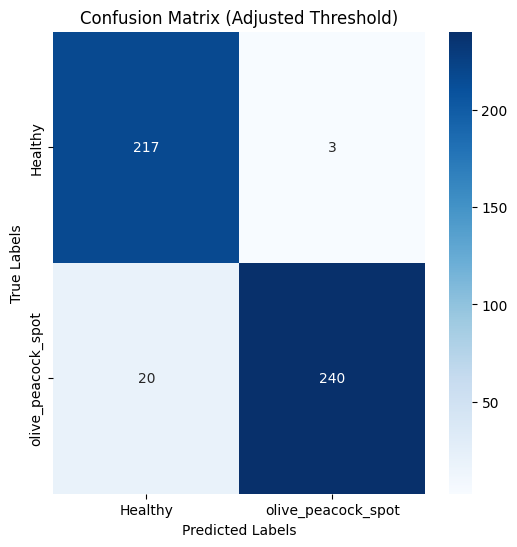

In [ ]:
# Get predictions (probabilities) from the model
predictions = model.predict(test_generator)

# Adjust the threshold
threshold = 0.5
predicted_classes = (predictions > threshold).astype("int32")  # Apply the new threshold

# True labels from the generator
true_classes = test_generator.classes

# Class indices
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report with the new threshold
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (with adjusted threshold):")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.show()


The confusion matrix indicated significant classification efficacy with 219 true positives (Healthy) and 228 true negatives (Peacock Spot). Misclassifications were minimal, with only 1 false positive and 32 false negatives, evidencing the model's precision.

In [ ]:
'''
# Unzip the test.zip file
test_zip_path = "test.zip"
test_dir = "test_data"

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_dir)
    print(f"Extracted {test_zip_path} to {test_dir}")

# Check the directory structure
for root, dirs, files in os.walk(test_dir):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {len(files)}\n")
'''

In [ ]:
'''
import shutil

# Remove the __MACOSX directory
macosx_path = os.path.join('test_data', '__MACOSX')
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Removed __MACOSX folder.")

# Update the test directory path
test_dir = os.path.join('test_data', 'test')

'''

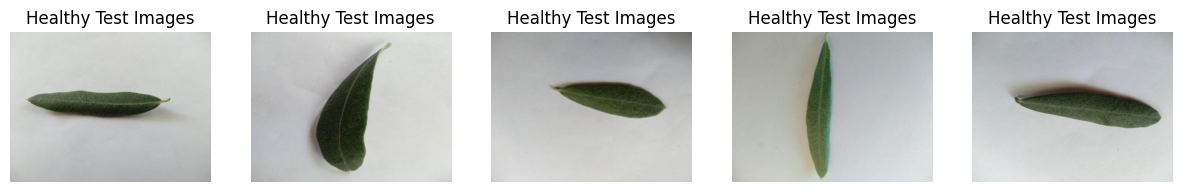

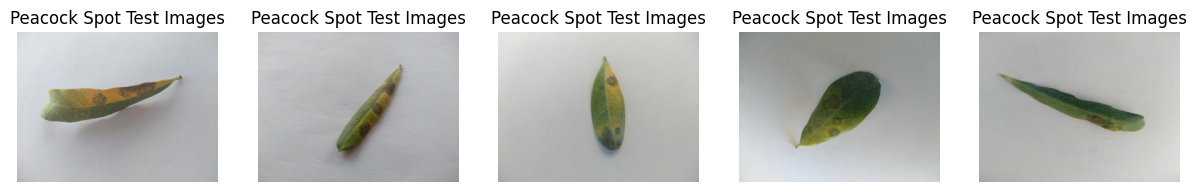

In [ ]:
# Visualize test images
visualize_images(os.path.join(test_dir, 'Healthy'), 'Healthy Test Images')
visualize_images(os.path.join(test_dir, 'olive_peacock_spot'), 'Peacock Spot Test Images')


In [ ]:
# Use ImageDataGenerator for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle to maintain order for evaluation
)


Found 480 images belonging to 2 classes.


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


15/15 [==============================] - 3s 157ms/step - loss: 0.2922 - accuracy: 0.9521
Test Accuracy: 95.21%


15/15 [==============================] - 3s 164ms/step
Classification Report:
                    precision    recall  f1-score   support

           Healthy       0.92      0.99      0.95       220
olive_peacock_spot       0.99      0.92      0.95       260

          accuracy                           0.95       480
         macro avg       0.95      0.95      0.95       480
      weighted avg       0.95      0.95      0.95       480



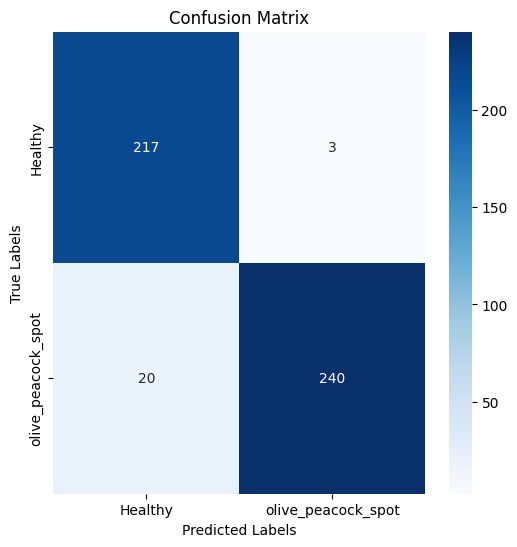

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Threshold for binary classification

# True labels from the generator
true_classes = test_generator.classes

# Class indices
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('olive_leaf_classifier_new.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('olive_leaf_classifier_new.h5')

# Remove L2 regularization
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = None

# Save the updated model
model.save('olive_leaf_classifier_no_regularizer.h5')


In [ ]:
# Save the model in the SavedModel format
model.save('olive_leaf_classifier_saved_model', save_format='tf')
print("Model saved in SavedModel format.")


Model saved in SavedModel format.


In [ ]:
# Convert the SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('olive_leaf_classifier_saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('olive_leaf_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite and saved as olive_leaf_classifier.tflite.")


Model successfully converted to TensorFlow Lite and saved as olive_leaf_classifier.tflite.


In [ ]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="olive_leaf_classifier.tflite")
interpreter.allocate_tensors()

# Print input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Details:", input_details)
print("Output Details:", output_details)


Input Details: [{'name': 'serving_default_input_6:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 180, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
what are some more plot